# Time Series with Deep Neural Networks

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

### Plotting helper functions

In [4]:
def plot_series(df, xlabel=None, ylabel=None, plot_title=''):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x = df.index, y=df.series,
                             mode='lines', name='Test'))
    xlabel = xlabel if xlabel else 'Time'
    ylabel = ylabel if ylabel else ''
    
    fig.update_layout(xaxis_title=xlabel,
                     yaxis_title=ylabel,
                     template='plotly_dark',
                     title=plot_title 
                     )
    
    fig.show()
    

## Generating time sequence data

In [10]:
def generate_series(length):
    df = pd.DataFrame(0, index=np.arange(0, length), columns=['series']) 
    df.index.name = 'time'
    return df

def white_noise(df, mu=0, sigma=1):
    df.series += sigma * np.random.randn(df.series.shape[0]) + mu
    return df

def trend(df, slope=1/365):
    df.series += slope * df.index
    return df

def seasonality(df, period=100, offset=0, scale=1):
    # Random periodic function
    f = lambda x: np.sin(x) + 1/6 * np.sin(2 * x) - 1/3 *  np.sin(3 * x)
    time = scale * f(2 * np.pi / period * df.index + offset)
    df.series += time 
    return df
    

example_series = white_noise(seasonality(trend(generate_series(1200))), sigma=0.5)



In [11]:
import tensorflow as tf
import keras 
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

We set up the helper function that will slice up the time series into features and labels. This practically means that n time steps are being used as features to predict the n+1 time step (the label).
Conveniently, this is taken care of by the TimeseriesGenerator from the Keras library.

In [12]:
def prepare_data(series, look_back=10, batch_size=1):
    return TimeseriesGenerator(series, series, length=look_back, batch_size=batch_size)

def train_test_split(df, train_share=0.8):
    n = int(df.shape[0] * train_share)
    # Note the difference here with RNN!! In RNN we reshape it to (-1, 1)
    data = df.series.to_numpy().reshape((-1))
    train_data = data[:n]
    test_data = data[n:]
    train_index = df.index[:n].to_numpy()
    test_index = df.index[n:].to_numpy()          
    augmented_test_data = data[n-look_back:]
    return train_data, train_index, test_data, test_index, augmented_test_data

## DNN model

In [35]:
look_back = 15
batch_size = 30

dnn_model = Sequential([
    Dense(10, input_shape=[look_back], activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/15)
)

optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
dnn_model.compile(loss="mse", optimizer=optimizer)

In [38]:
train_data, train_index, test_data, test_index, augmented_test_data = train_test_split(example_series)

train_generator = prepare_data(train_data, look_back=look_back, batch_size=batch_size)
test_generator = prepare_data(test_data, look_back=look_back, batch_size=1)
augmented_test_generator = prepare_data(augmented_test_data, look_back=look_back, batch_size=1)

history = dnn_model.fit(train_generator, epochs=500, verbose=0, callbacks=[lr_schedule])

(1e-08, 0.001, 0.0, 10.0)

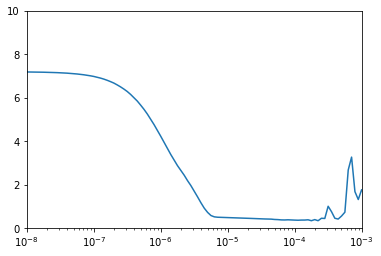

In [41]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"][:])
plt.axis([1e-8, 1e-3, 0, 10])

In [42]:
dnn_model = Sequential([
    Dense(10, input_shape=[look_back], activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])


optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
dnn_model.compile(loss="mse", optimizer=optimizer)
history = dnn_model.fit(train_generator, epochs=500, verbose=0)

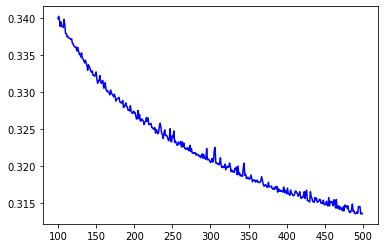

In [45]:
loss = history.history['loss']
epochs = range(100,len(loss))
plt.plot(epochs, loss[100:], 'b', label='Training Loss')
plt.show()

In [46]:
prediction = dnn_model.predict(augmented_test_generator)

prediction = prediction.reshape((-1))

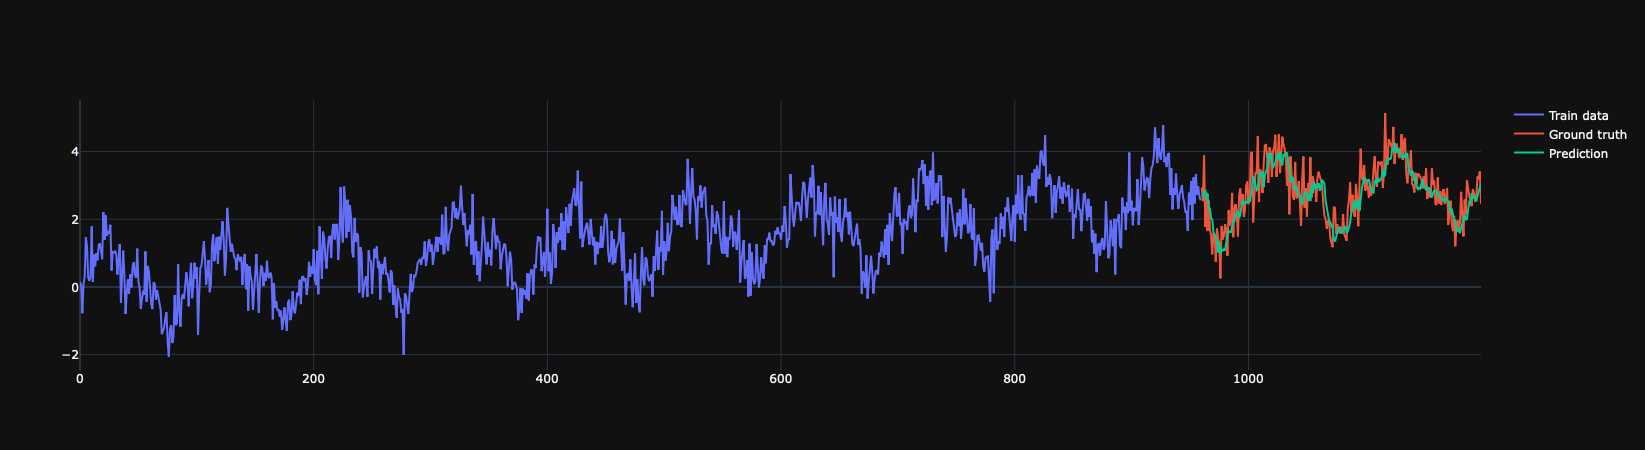

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_index, 
                         y=train_data, 
                         name='Train data'
                        )
             )
                                          
             

fig.add_trace(go.Scatter(x=test_index, 
                         y=test_data, 
                         name='Ground truth'
                        )
             ) 

fig.add_trace(go.Scatter(x=test_index, 
                         y=prediction, 
                         name='Prediction'
                        )
             )

fig.update_layout(template='plotly_dark')
fig.show()



In [48]:
from keras.metrics import mse

mse(prediction, test_data).numpy()

0.30608526